In [1]:
import intake
import seaborn as sns; sns.set()
%matplotlib inline

<table style="margin: 0px auto; bgcolor="#fff">
    <tr bgcolor="#fff">
        <td>
            <img src="https://intake.readthedocs.io/en/latest/_static/images/logo.png" alt="Intake" width=150>
        </td>
    </tr>
    <tr>
        <td height="50">
            <a href="https://intake.readthedocs.io" style="font-size: 20px;">https://intake.readthedocs.io</a>
        </td>
    </tr>
</table>

# Taking the pain out of data access and distribution

[Intake](https://intake.readthedocs.io/en/latest/index.html) is a Python package for loading, investigating, and organizing data.  From the perspective of a **data analyst**, it has the following features

 * Loads data into containers you already use: NumPy arrays, Pandas/Dask Dataframes, etc.
 * Reduces boilerplate code
 * Facilitates reusable workflows
 * Install datasets as Python packages
 * "Self-describing" data sources
 * "Quick look" plotting

Below we'll import a built-in *catalog* of data sources from Intake.  We can then list the contents of these data sources. 

In [2]:
from intake import cat
list(cat)

['poro_perm',
 'production_by_state',
 'production_by_api',
 'tickers_by_state',
 'well_location_by_ticker_and_state',
 'well_location_by_api']

Each of the entries in the list above are *data sources*, most of them take parameters as arguments from the user to modify exactly what data gets loaded.  The data sources get the data from remote SQL servers as well as locally installed CSV files.  Exactly where the data comes from is intentionally abstracted from the *data analyst*, freeing them to focus on the workflows that use the data.

We'll later show how these data sources have methods that help investigate the user parameters and other descriptions, but for now let's quickly look at an example of loading some data.

Here we will load the total production histories (oil, gas, water) from a well identified by the API number '33007000110000'.  This command executes a SQL query to a data base and returns a [Panda](https://pandas.pydata.org/)'s dataframe.

In these tutorials, we attempt to not use packages that haven't been introduced yet, and we will cover Panda's in detail later, but we use Intake to load data in essentially every tutorial, you'll have to excuse the premature use of Panda's as well as a few plotting utilities as they are used only for the purposes of demonstrating Intake.

In [3]:
df = cat.production_by_api(api='33007000110000').read()

df.set_index(['date']).head()

,volume_oil_formation_bbls,volume_gas_formation_mcf,volume_water_formation_bbls
date,,,
2011-09-01,4,0,0
2011-08-01,36,14,86
2011-07-01,257,126,852
2011-06-01,247,109,952
2011-05-01,41,11,118


# Reduce boilerplate code

The following code is requried to reproduce the functionality we've demonstrated with a one line command from Intake. The steps here include loading required modules, loading environment variables, formatting the URL for the PostgresSQL database connection, formatting a SQL statement given an API number as an argument to the function `query_api`, and finally, using the [Panda's `read_sql()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_sql.html) function to load the data into a DataFrame object.

In [4]:
import os
import pandas as pd

os.environ['BAZEAN_POSTGRES_USERNAME'] = 'jfoster'
os.environ['BAZEAN_POSTGRES_PASSWORD'] = 'och6Eexe'

username = os.environ['BAZEAN_POSTGRES_USERNAME']
password = os.environ['BAZEAN_POSTGRES_PASSWORD']

engine = 'postgresql://{}:{}@premium-west.bazean.com:5432/db'.format(username, password)

def query_api(api):
    """
        Return SQL statement to get production given an API Number
    """
    return "SELECT date,volume_oil_formation_bbls," \
                   "volume_gas_formation_mcf," \
                   "volume_water_formation_bbls " \
                   "FROM public.production_all WHERE api='{}'".format(api)

pd.read_sql(query_api(api='33007000110000'), engine, parse_dates=['date']).head(3)

,date,volume_oil_formation_bbls,volume_gas_formation_mcf,volume_water_formation_bbls
0,2011-09-01,4,0,0
1,2011-08-01,36,14,86
2,2011-07-01,257,126,852


Compare with

In [5]:
cat.production_by_api(api='33007000110000').read().head(3)

,date,volume_oil_formation_bbls,volume_gas_formation_mcf,volume_water_formation_bbls
index,,,,
0,2011-09-01,4,0,0
1,2011-08-01,36,14,86
2,2011-07-01,257,126,852


# Reusable workflows

Sometimes you may have data that comes from different sources, but you would like to reuse a common workflow to analyize the data.  For example, one set of data from a PostgresSQL database and another set stored in CSV files, the *data engineer* can set up catalogs such that the data has the same structure, and the *data analyst* can use an identical workflow.

Below is a simple plotting workflow that takes as arguments an Intake catalog and an API number as arguments and formats a plot to show the production histories of gas and oil for a well identified by the API number.

In [6]:
def my_fancy_plotting_workflow(catalog, api):
    """
       Creates a plot given a dataframe with a column labeled 'date'
    """
    dataframe = catalog.production_by_api(api=api).read()
    ax1 = dataframe.set_index(['date']).plot(y=['volume_oil_formation_bbls'])
    ax2 = dataframe.set_index(['date']).plot(y=['volume_gas_formation_mcf'], ax=ax1, secondary_y=True)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Production (BBLS)')
    ax2.set_ylabel('Production (MCF)')
    
    handles = []
    for ax in [ax1, ax2]:
        for h,_ in zip(*ax.get_legend_handles_labels()):
            handles.append(h)
    ax1.legend(handles,['Oil', 'Gas (right)']) 
    return ax1

Using the same catalog introduced earlier with our plotting function `my_fancy_plotting_workflow()`.

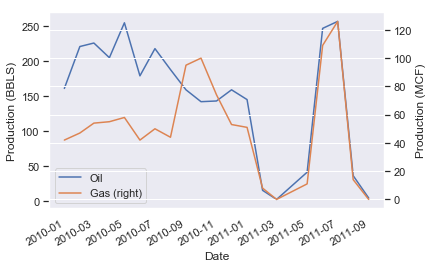

In [7]:
my_fancy_plotting_workflow(cat, api='33007000110000');

## Write to CSV

Now we'll play data engineer momentarily.  We'll read in the production data from a couple of wells and immediately write them to CSV files stored in a local hidden directory named `.files`.  The detailed syntax of the following is not important at the moment.  Just understand that we are reading data from the PostgresSQL database and then storing  them locally.

In [8]:
cat.production_by_api(api='33007000110000').read().to_csv('.files/production_33007000110000.csv', index=False)
cat.production_by_api(api='33007000140000').read().to_csv('.files/production_33007000140000.csv', index=False)

We can verify the files were written by listing the files in the directory `.files`.

In [9]:
ls .files

nd_production.yml              production_33007000140000.csv
production_33007000110000.csv


Inspecting the contents of one of the files, by looking at the first 5 lines in the file.

In [10]:
!head -n 5 .files/production_33007000110000.csv

date,volume_oil_formation_bbls,volume_gas_formation_mcf,volume_water_formation_bbls
2011-09-01,4,0,0
2011-08-01,36,14,86
2011-07-01,257,126,852
2011-06-01,247,109,952


# Use Intake to read CSV file and create a local catalog

Now we'll use Intake's [`open_csv()`](https://intake.readthedocs.io/en/latest/quickstart.html) function to read the CSV file back into a new catalog called `csv_cat`.  This catalog object has a method `.yaml()` that will produce a description of the catalog using YAML syntax.  We can then minimally edit this output to create a local catalog that we can use for reading in CSV files with an arbitrary API number.

In [11]:
csv_cat = intake.open_csv('./files/production_33007000110000.csv', csv_kwargs={'parse_dates': ['date']})

print(csv_cat.yaml())

sources:
  csv:
    args:
      csv_kwargs:
        parse_dates:
        - date
      urlpath: ./files/production_33007000110000.csv
    description: ''
    driver: intake.source.csv.CSVSource
    metadata: {}



# Edit YAML and write catalog file

You can inspect the changes between what's above and the edits below.  We rename the data source "csv" to "production_by_api" and using the replacement syntax `{{}}` create a user parameter `api` that replaces the explicit API number above.

In [12]:
%%file ".files/nd_production.yml"
sources: 
  production_by_api:
    args:
      csv_kwargs:
        parse_dates:
        - date
      urlpath: '{{ CATALOG_DIR }}/production_{{api}}.csv'
    description: 'Returns production history given an API'
    driver: intake.source.csv.CSVSource
    metadata: {}

Overwriting .files/nd_production.yml


# Read in local catalog file and execute workflow

In [13]:
csv_cat = intake.open_catalog(".files/nd_production.yml")
list(csv_cat)

['production_by_api']

In [ ]:
my_fancy_plotting_workflow(cat, api='33007000110000');

# Install data as Python packages

For example, with `conda`

```
conda install -c daytum data
```

Here we use the package manager `conda` to install a package named "data" from the "daytum" channel.  This is extremely useful from a data engineer perspective because you can "version control" data and take advantage of `conda update`, etc.

# "Self-describing" Data

The `.describe()` method when called on data sources returns a description, user parameters, and other metadata.

In [14]:
cat.production_by_state.describe()

{'container': 'dataframe',
 'description': 'Production history for all wells in a user parameter given state.',
 'direct_access': 'forbid',
 'user_parameters': [{'name': 'bazean_postgres_username',
   'description': 'PostgresSQL username for accessing Bazean database',
   'type': 'str',
   'default': 'env(BAZEAN_POSTGRES_USERNAME)'},
  {'name': 'bazean_postgres_password',
   'description': 'PostgresSQL password for accessing Bazean database',
   'type': 'str',
   'default': 'env(BAZEAN_POSTGRES_PASSWORD)'},
  {'name': 'subdomain',
   'description': 'Bazean PostgresSQL subdomain name',
   'type': 'str',
   'default': 'premium-west'},
  {'name': 'schema',
   'description': 'Bazean PostgresSQL database schema',
   'type': 'str',
   'default': 'public'},
  {'name': 'state',
   'description': 'State to query production',
   'type': 'str',
   'allowed': ['OH',
    'MI',
    'WV',
    'CA',
    'ND',
    'BC',
    'KS',
    'MT',
    'UT',
    'PA',
    'AR',
    'LA',
    'WY',
    'OK',
   

# GUI

There is a built in  GUI which also allows for exploration of data sources.  The search feature is particularly useful.

In [24]:
intake.gui

Intake GUI instance: to get widget to display, you must install ipy/jupyter-widgets, run in a notebook and, in the case of jupyter-lab, install the jlab extension.

# Built-in quick look plotting

If the plotting package [Holoviews](http://holoviews.org/) is installed, you can load quick view plots of the data, much like Panda's.  Line, Bar, Scatter, and several other types of plots are built in, see [the documention](https://intake.readthedocs.io/en/latest/plotting.html) for more information.  The data engineer can define custom plot specifications in the metadata of the catalog.

Below is an example of creating a scatter plot with the `poro_perm` data source without any arguments or custimization.

In [26]:
import hvplot.intake

cat.poro_perm.plot.scatter()

:NdOverlay   [Variable]
   :Scatter   [index]   (value)

A more useful plot is defined as `my_scatter()` in the catalog.

In [17]:
cat.poro_perm.plot.my_scatter()

:Scatter   [porosity]   (permeability)

# Persisting Data

Calling the method `.persist()` on a data source will create a local copy in a storage format that is most suitable to the container.  This is useful for large queries across networks or when working with big datasets (assuming you have the local hard drive storage capacity).  Once the data has been persisted, it will load much faster in subsequent calls.  This can be demonstrated by using the Jupyter notebooks `%%timeit` magic function.

In [20]:
%timeit df = cat.production_by_api(api='33007000110000', persist='never').read()

1.32 s ± 10.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


To create a local copy, just call the method `.persist()`

```python
cat.production_by_api(api='33007000110000').persist()
```

In [21]:
%timeit df = cat.production_by_api(api='33007000110000').read()

29.4 ms ± 4.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
%%javascript
function hideElements(elements, start) {
for(var i = 0, length = elements.length; i < length;i++) {
    if(i >= start) {
        elements[i].style.display = "none";
    }
}
}
var prompt_elements = document.getElementsByClassName("prompt");
hideElements(prompt_elements, 0)

<IPython.core.display.Javascript object>